In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="thG33xUjGSCIzbllIF4X")
project = rf.workspace("seher-pvagg").project("yatak-yarasi")
version = project.version(1)
dataset = version.download("multiclass")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to yatak-yarasi-1 in multiclass:: 100%|██████████| 1796/1796 [00:02<00:00, 699.31it/s] 


In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 13.5 MB/s eta 0:00:00


In [3]:
import os
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp.solutions.pose.Pose(
                              model_complexity=2,
                              min_detection_confidence=0.5,
                              min_tracking_confidence=0.5
                              )

In [5]:
# Path to the dataset directory and DataFrame
train_dir = '/content/yatak-yarasi-1/train'
df = pd.read_csv('/content/yatak-yarasi-1/train/_classes.csv')  # Update path if necessary
df.columns = df.columns.str.strip()
df['labels'] = df[['saga yatik', 'sirt ustu', 'sola yatik', 'yuz ustu']].apply(
    lambda row: [label for label, value in zip(['saga yatik', 'sirt ustu', 'sola yatik', 'yuz ustu'], row) if value == 1],
    axis=1)

# List to store pose estimations for each image
pose_estimations = []

# Iterate through each image in the dataset
for index, row in df.iterrows():
    image_path = os.path.join(train_dir, row['filename'])
    image = cv2.imread(image_path)

    if image is None:
        print(f"Warning: Image {row['filename']} not found in {train_dir}")
        continue

    # Convert the image to RGB for Mediapipe processing
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    rows, cols, _ = image.shape
    landmarks = []

    # Process pose landmarks if detected
    if results.pose_landmarks:
        if len(results.pose_landmarks.landmark) == 33:
            # Loop through each of the 33 pose landmarks and store their y coordinates
            for lm in results.pose_landmarks.landmark:
                cy = int(lm.y * rows)  # Get y-coordinate (scaled to image height)
                landmarks.append(cy)  # Append the y-coordinate

            # Append the pose estimation and corresponding class label to the list
            pose_estimations.append({"class_label": row['labels'], "pose": landmarks})

# Convert the pose estimations to a DataFrame for saving or further processing
pose_df = pd.DataFrame(pose_estimations)

# Flatten the 'pose' column (which contains lists) into separate columns for each point
pose_df_expanded = pose_df['pose'].apply(pd.Series)

# Explicitly assign column names for 33 pose points
pose_df_expanded.columns = [f"point_{i+1}" for i in range(33)]

# Combine the class label with the pose points
pose_df_expanded['class_label'] = pose_df['class_label']

# Reorder columns to have class label first
pose_df_expanded = pose_df_expanded[['class_label'] + [f"point_{i+1}" for i in range(33)]]

# Save to CSV
pose_df_expanded.to_csv('pose_estimations_y_only_train.csv', index=False)
print("Pose estimation (y-coordinates only) with class labels saved to pose_estimations_y_only.csv")


Pose estimation (y-coordinates only) with class labels saved to pose_estimations_y_only.csv


In [6]:
df1=pd.read_csv("/content/pose_estimations_y_only_train.csv")
df1.head()

,class_label,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_24,point_25,point_26,point_27,point_28,point_29,point_30,point_31,point_32,point_33
0,['sirt ustu'],277,274,275,275,274,273,273,278,275,...,343,335,413,397,481,471,492,482,499,487
1,['sirt ustu'],338,344,349,354,334,331,328,361,325,...,364,311,363,310,354,320,354,330,332,275
2,['sirt ustu'],476,482,482,482,482,482,481,478,477,...,308,317,223,232,139,153,131,147,108,114
3,['sola yatik'],361,366,366,365,369,369,370,365,373,...,273,299,223,322,215,321,214,310,212,341
4,['yuz ustu'],400,405,405,404,407,407,408,401,406,...,275,299,401,400,450,458,451,456,488,495


In [7]:
df1.shape #779train

(782, 34)

In [8]:
# Path to the dataset directory and DataFrame
valid_dir = '/content/yatak-yarasi-1/valid'
df = pd.read_csv('/content/yatak-yarasi-1/valid/_classes.csv')  # Update path if necessary
df.columns = df.columns.str.strip()
df['labels'] = df[['saga yatik', 'sirt ustu', 'sola yatik', 'yuz ustu']].apply(
    lambda row: [label for label, value in zip(['saga yatik', 'sirt ustu', 'sola yatik', 'yuz ustu'], row) if value == 1],
    axis=1)

# List to store pose estimations for each image
pose_estimations = []

# Iterate through each image in the dataset
for index, row in df.iterrows():
    image_path = os.path.join(valid_dir, row['filename'])
    image = cv2.imread(image_path)

    if image is None:
        print(f"Warning: Image {row['filename']} not found in {train_dir}")
        continue

    # Convert the image to RGB for Mediapipe processing
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    rows, cols, _ = image.shape
    landmarks = []

    # Process pose landmarks if detected
    if results.pose_landmarks:
        if len(results.pose_landmarks.landmark) == 33:
            # Loop through each of the 33 pose landmarks and store their y coordinates
            for lm in results.pose_landmarks.landmark:
                cy = int(lm.y * rows)  # Get y-coordinate (scaled to image height)
                landmarks.append(cy)  # Append the y-coordinate

            # Append the pose estimation and corresponding class label to the list
            pose_estimations.append({"class_label": row['labels'], "pose": landmarks})

# Convert the pose estimations to a DataFrame for saving or further processing
pose_df = pd.DataFrame(pose_estimations)

# Flatten the 'pose' column (which contains lists) into separate columns for each point
pose_df_expanded = pose_df['pose'].apply(pd.Series)

# Explicitly assign column names for 33 pose points
pose_df_expanded.columns = [f"point_{i+1}" for i in range(33)]

# Combine the class label with the pose points
pose_df_expanded['class_label'] = pose_df['class_label']

# Reorder columns to have class label first
pose_df_expanded = pose_df_expanded[['class_label'] + [f"point_{i+1}" for i in range(33)]]

# Save to CSV
pose_df_expanded.to_csv('pose_estimations_y_only_valid.csv', index=False)
print("Pose estimation (y-coordinates only) with class labels saved to pose_estimations_y_only.csv")

Pose estimation (y-coordinates only) with class labels saved to pose_estimations_y_only.csv


In [9]:
df2=pd.read_csv("/content/pose_estimations_y_only_valid.csv")
df2.head()

,class_label,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_24,point_25,point_26,point_27,point_28,point_29,point_30,point_31,point_32,point_33
0,['sola yatik'],295,294,293,293,293,293,293,287,284,...,372,334,387,228,454,156,466,129,466,104
1,['sirt ustu'],277,272,275,278,263,260,257,281,254,...,424,399,486,450,545,519,555,534,559,534
2,['sirt ustu'],156,141,139,138,142,142,142,136,139,...,351,328,458,410,539,464,552,480,589,508
3,['sola yatik'],337,340,343,345,332,328,322,343,303,...,412,391,449,404,413,384,402,388,412,364
4,['sirt ustu'],283,281,281,281,281,281,282,285,286,...,377,389,436,449,505,531,521,540,508,558


In [10]:
df2.shape #87valid

(62, 34)

In [11]:
# Path to the dataset directory and DataFrame
test_dir = '/content/yatak-yarasi-1/test'
df = pd.read_csv('/content/yatak-yarasi-1/test/_classes.csv')  # Update path if necessary
df.columns = df.columns.str.strip()
df['labels'] = df[['saga yatik', 'sirt ustu', 'sola yatik', 'yuz ustu']].apply(
    lambda row: [label for label, value in zip(['saga yatik', 'sirt ustu', 'sola yatik', 'yuz ustu'], row) if value == 1],
    axis=1)

# List to store pose estimations for each image
pose_estimations = []

# Iterate through each image in the dataset
for index, row in df.iterrows():
    image_path = os.path.join(test_dir, row['filename'])
    image = cv2.imread(image_path)

    if image is None:
        print(f"Warning: Image {row['filename']} not found in {train_dir}")
        continue

    # Convert the image to RGB for Mediapipe processing
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    rows, cols, _ = image.shape
    landmarks = []

    # Process pose landmarks if detected
    if results.pose_landmarks:
        if len(results.pose_landmarks.landmark) == 33:
            # Loop through each of the 33 pose landmarks and store their y coordinates
            for lm in results.pose_landmarks.landmark:
                cy = int(lm.y * rows)  # Get y-coordinate (scaled to image height)
                landmarks.append(cy)  # Append the y-coordinate

            # Append the pose estimation and corresponding class label to the list
            pose_estimations.append({"class_label": row['labels'], "pose": landmarks})

# Convert the pose estimations to a DataFrame for saving or further processing
pose_df = pd.DataFrame(pose_estimations)

# Flatten the 'pose' column (which contains lists) into separate columns for each point
pose_df_expanded = pose_df['pose'].apply(pd.Series)

# Explicitly assign column names for 33 pose points
pose_df_expanded.columns = [f"point_{i+1}" for i in range(33)]

# Combine the class label with the pose points
pose_df_expanded['class_label'] = pose_df['class_label']

# Reorder columns to have class label first
pose_df_expanded = pose_df_expanded[['class_label'] + [f"point_{i+1}" for i in range(33)]]

# Save to CSV
pose_df_expanded.to_csv('pose_estimations_y_only_test.csv', index=False)
print("Pose estimation (y-coordinates only) with class labels saved to pose_estimations_y_only.csv")

Pose estimation (y-coordinates only) with class labels saved to pose_estimations_y_only.csv


In [12]:
df=pd.read_csv("/content/pose_estimations_y_only_test.csv")
df.head()

,class_label,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_24,point_25,point_26,point_27,point_28,point_29,point_30,point_31,point_32,point_33
0,['sirt ustu'],104,101,103,106,98,98,97,116,105,...,291,278,386,357,488,466,500,487,526,498
1,['yuz ustu'],129,115,115,115,115,114,114,125,120,...,351,338,391,385,544,478,566,495,568,498
2,['yuz ustu'],326,322,322,321,323,323,323,316,318,...,330,327,411,381,448,350,452,348,457,341
3,['sola yatik'],497,506,506,505,509,510,512,504,512,...,320,329,249,254,153,148,146,141,106,101
4,['sola yatik'],360,367,370,372,364,364,363,387,376,...,307,303,265,297,364,331,369,334,404,352


In [13]:
df.shape #38test

(37, 34)

In [14]:
data=pd.concat([df1,df2,df],axis=0)
data.shape

(881, 34)

In [15]:
data.duplicated().sum()

0

In [16]:
data.to_csv("pose_estimation_data.csv",index=False)

# **ML Model**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Read Dataset**

In [18]:
data = pd.read_csv('pose_estimation_data.csv')

In [19]:
data.head()

,class_label,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_24,point_25,point_26,point_27,point_28,point_29,point_30,point_31,point_32,point_33
0,['sirt ustu'],277,274,275,275,274,273,273,278,275,...,343,335,413,397,481,471,492,482,499,487
1,['sirt ustu'],338,344,349,354,334,331,328,361,325,...,364,311,363,310,354,320,354,330,332,275
2,['sirt ustu'],476,482,482,482,482,482,481,478,477,...,308,317,223,232,139,153,131,147,108,114
3,['sola yatik'],361,366,366,365,369,369,370,365,373,...,273,299,223,322,215,321,214,310,212,341
4,['yuz ustu'],400,405,405,404,407,407,408,401,406,...,275,299,401,400,450,458,451,456,488,495


In [20]:
data.shape

(881, 34)

In [21]:
data.columns

Index(['class_label', 'point_1', 'point_2', 'point_3', 'point_4', 'point_5',
       'point_6', 'point_7', 'point_8', 'point_9', 'point_10', 'point_11',
       'point_12', 'point_13', 'point_14', 'point_15', 'point_16', 'point_17',
       'point_18', 'point_19', 'point_20', 'point_21', 'point_22', 'point_23',
       'point_24', 'point_25', 'point_26', 'point_27', 'point_28', 'point_29',
       'point_30', 'point_31', 'point_32', 'point_33'],
      dtype='object')

In [22]:
data.dtypes

,0
class_label,object
point_1,int64
point_2,int64
point_3,int64
point_4,int64
point_5,int64
point_6,int64
point_7,int64
point_8,int64
point_9,int64


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 34 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_label  881 non-null    object
 1   point_1      881 non-null    int64 
 2   point_2      881 non-null    int64 
 3   point_3      881 non-null    int64 
 4   point_4      881 non-null    int64 
 5   point_5      881 non-null    int64 
 6   point_6      881 non-null    int64 
 7   point_7      881 non-null    int64 
 8   point_8      881 non-null    int64 
 9   point_9      881 non-null    int64 
 10  point_10     881 non-null    int64 
 11  point_11     881 non-null    int64 
 12  point_12     881 non-null    int64 
 13  point_13     881 non-null    int64 
 14  point_14     881 non-null    int64 
 15  point_15     881 non-null    int64 
 16  point_16     881 non-null    int64 
 17  point_17     881 non-null    int64 
 18  point_18     881 non-null    int64 
 19  point_19     881 non-null    

In [24]:
data.isnull().head()

,class_label,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_24,point_25,point_26,point_27,point_28,point_29,point_30,point_31,point_32,point_33
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
data.isnull().sum()

,0
class_label,0
point_1,0
point_2,0
point_3,0
point_4,0
point_5,0
point_6,0
point_7,0
point_8,0
point_9,0


<Axes: >

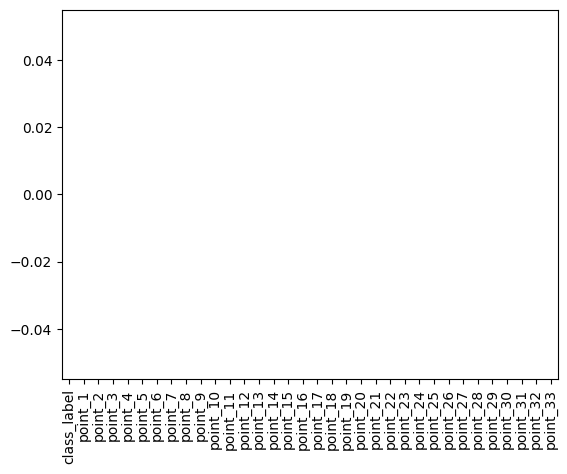

In [26]:
data.isnull().sum().plot(kind = 'bar')

# **Pre-Processing**

In [27]:
#from sklearn.impute import SimpleImputer
#impute = SimpleImputer(missing_value = np.nan, strategy = 'most_frequent')
#data[''] = impute.fit_transform(data[['']]).ravel()

In [28]:
data.duplicated().sum()

0

In [29]:
#data.drop_duplicates(inplace = True)
#data.duplicated().sum()

In [30]:
cols = list(data.nunique().sort_values())
cols

[5,
 247,
 250,
 334,
 334,
 336,
 349,
 363,
 365,
 384,
 395,
 396,
 402,
 403,
 405,
 407,
 411,
 415,
 418,
 419,
 420,
 421,
 421,
 421,
 422,
 427,
 428,
 436,
 441,
 447,
 450,
 463,
 499,
 500]

In [31]:
data['point_1'].max(), data['point_1'].min(), data['point_1'].median(), data['point_1'].mean(), data['point_1'].std()

(1673, 42, 331.0, 322.8433598183882, 151.7162587307117)

# **Visualization**

In [32]:
data.head()

,class_label,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_24,point_25,point_26,point_27,point_28,point_29,point_30,point_31,point_32,point_33
0,['sirt ustu'],277,274,275,275,274,273,273,278,275,...,343,335,413,397,481,471,492,482,499,487
1,['sirt ustu'],338,344,349,354,334,331,328,361,325,...,364,311,363,310,354,320,354,330,332,275
2,['sirt ustu'],476,482,482,482,482,482,481,478,477,...,308,317,223,232,139,153,131,147,108,114
3,['sola yatik'],361,366,366,365,369,369,370,365,373,...,273,299,223,322,215,321,214,310,212,341
4,['yuz ustu'],400,405,405,404,407,407,408,401,406,...,275,299,401,400,450,458,451,456,488,495




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='class_label', ylabel='count'>

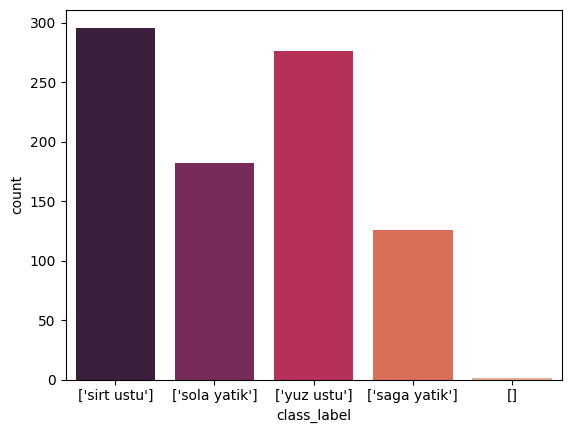

In [33]:
sns.countplot(data = data, x = "class_label", palette = 'rocket')

In [34]:
cols = list(data.nunique().sort_values().index[:7])
cols

['class_label',
 'point_24',
 'point_25',
 'point_27',
 'point_26',
 'point_14',
 'point_15']

In [35]:
for n, col in enumerate(cols): # Iterate over the cols list directly
  print(n, col)
# enumerate -> return (index) and the (name of columns)

0 class_label
1 point_24
2 point_25
3 point_27
4 point_26
5 point_14
6 point_15


<Axes: xlabel='class_label', ylabel='count'>

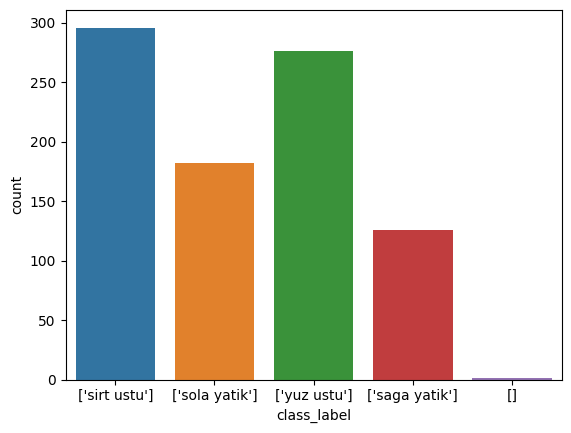

In [36]:
sns.countplot(data = data, x = 'class_label', hue = 'class_label')
#plt.xticks(rotation = 90)

<Axes: xlabel='class_label', ylabel='point_1'>

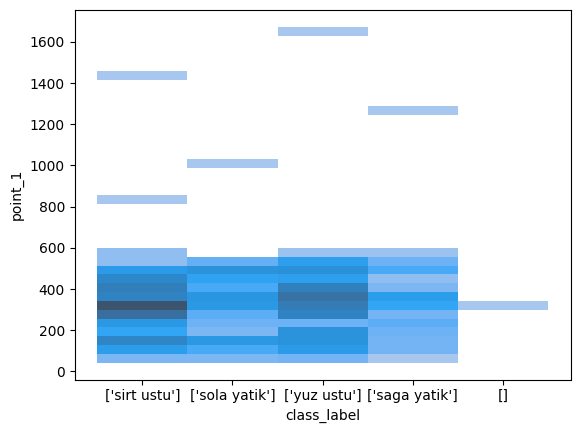

In [37]:
sns.histplot(data = data, x = "class_label", y = "point_1")

<Axes: xlabel='class_label', ylabel='point_1'>

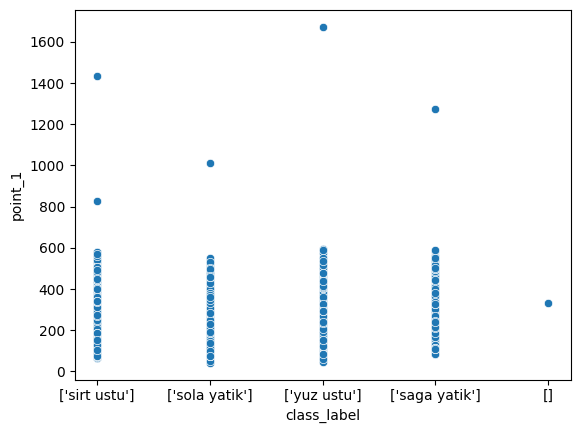

In [38]:
sns.scatterplot(data = data, x = "class_label", y = "point_1")

In [39]:
data.shape

(881, 34)

# **Encoding**

In [40]:
cols = data.dtypes[data.dtypes == 'object'].index
cols

Index(['class_label'], dtype='object')

In [41]:
data.nunique()

,0
class_label,5
point_1,411
point_2,436
point_3,421
point_4,428
point_5,421
point_6,418
point_7,422
point_8,415
point_9,427


In [42]:
#for i in list (data.columns):
#  print(i)

# **Scaling**

In [43]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
for c in ['class_label']:
  lb = LabelEncoder()
  data[c] = lb.fit_transform(data[c])

In [44]:
cols.astype('object')
#cols.values

Index(['class_label'], dtype='object')

In [45]:
data.describe()

,class_label,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_24,point_25,point_26,point_27,point_28,point_29,point_30,point_31,point_32,point_33
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,...,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,1.693530,322.843360,322.161180,322.002270,322.001135,322.667423,322.931896,323.095346,321.467650,322.964813,...,316.759364,319.031782,331.207719,329.111237,341.444949,340.013621,342.711691,340.254257,348.511918,345.730988
std,1.064538,151.716259,157.449736,157.380741,157.192864,157.898067,158.173753,158.530747,154.938512,156.882005,...,83.752144,99.291897,113.045018,119.556021,168.476211,170.601589,176.612637,178.639279,196.599010,197.436322
min,0.000000,42.000000,32.000000,32.000000,32.000000,34.000000,35.000000,36.000000,38.000000,40.000000,...,23.000000,18.000000,-123.000000,-135.000000,-349.000000,-406.000000,-381.000000,-445.000000,-442.000000,-500.000000
25%,1.000000,210.000000,203.000000,202.000000,201.000000,203.000000,203.000000,204.000000,202.000000,204.000000,...,278.000000,282.000000,250.000000,254.000000,198.000000,199.000000,194.000000,191.000000,185.000000,188.000000
50%,2.000000,331.000000,329.000000,328.000000,328.000000,331.000000,332.000000,331.000000,327.000000,332.000000,...,318.000000,319.000000,349.000000,345.000000,366.000000,360.000000,366.000000,364.000000,371.000000,366.000000
75%,3.000000,418.000000,422.000000,421.000000,423.000000,422.000000,421.000000,422.000000,423.000000,418.000000,...,351.000000,352.000000,406.000000,397.000000,482.000000,470.000000,492.000000,482.000000,515.000000,510.000000
max,4.000000,1673.000000,1650.000000,1643.000000,1636.000000,1666.000000,1670.000000,1674.000000,1629.000000,1685.000000,...,1383.000000,1615.000000,1216.000000,1478.000000,1120.000000,1438.000000,1083.000000,1414.000000,1207.000000,1497.000000


In [46]:
onehotencoder = OneHotEncoder()
x = onehotencoder.fit_transform(np.array(data['class_label']).reshape(-1,1)).toarray()

for i in range(x.shape[1]):
    data[str(i)] = x[:, i]

In [47]:
data.head()

,class_label,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_29,point_30,point_31,point_32,point_33,0,1,2,3,4
0,1,277,274,275,275,274,273,273,278,275,...,471,492,482,499,487,0.0,1.0,0.0,0.0,0.0
1,1,338,344,349,354,334,331,328,361,325,...,320,354,330,332,275,0.0,1.0,0.0,0.0,0.0
2,1,476,482,482,482,482,482,481,478,477,...,153,131,147,108,114,0.0,1.0,0.0,0.0,0.0
3,2,361,366,366,365,369,369,370,365,373,...,321,214,310,212,341,0.0,0.0,1.0,0.0,0.0
4,3,400,405,405,404,407,407,408,401,406,...,458,451,456,488,495,0.0,0.0,0.0,1.0,0.0


In [48]:
data.dtypes

,0
class_label,int64
point_1,int64
point_2,int64
point_3,int64
point_4,int64
point_5,int64
point_6,int64
point_7,int64
point_8,int64
point_9,int64


# **Splitting**

In [49]:
from sklearn.model_selection import train_test_split
x = data.drop(["class_label"], axis = 1)
y = data["class_label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [50]:
data.head()

,class_label,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_29,point_30,point_31,point_32,point_33,0,1,2,3,4
0,1,277,274,275,275,274,273,273,278,275,...,471,492,482,499,487,0.0,1.0,0.0,0.0,0.0
1,1,338,344,349,354,334,331,328,361,325,...,320,354,330,332,275,0.0,1.0,0.0,0.0,0.0
2,1,476,482,482,482,482,482,481,478,477,...,153,131,147,108,114,0.0,1.0,0.0,0.0,0.0
3,2,361,366,366,365,369,369,370,365,373,...,321,214,310,212,341,0.0,0.0,1.0,0.0,0.0
4,3,400,405,405,404,407,407,408,401,406,...,458,451,456,488,495,0.0,0.0,0.0,1.0,0.0


# **Algorithms**

# **Decision Tree**

In [51]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(criterion = 'entropy', max_depth = None)
DT.fit(x_train, y_train)
y_pred = DT.predict(x_test)

#to calculate error
DT.score(x_test, y_test)
#ORRR
DT.score(x_train, y_train)

1.0

In [52]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average = 'weighted'))
print(recall_score(y_test, y_pred, average = 'weighted'))
print(f1_score(y_test, y_pred, average = 'weighted'))

[[32  0  0  0]
 [ 0 59  0  0]
 [ 0  0 37  0]
 [ 0  0  0 49]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        37
           3       1.00      1.00      1.00        49

    accuracy                           1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177

1.0
1.0
1.0
1.0


In [53]:
data = {
    'y_test': y_test,
    'y_pred': y_pred,
    'diff' : y_test - y_pred
}
df = pd.DataFrame(data)
df.head()

,y_test,y_pred,diff
350,1,1,0
254,1,1,0
490,0,0,0
688,1,1,0
393,1,1,0


<Axes: >

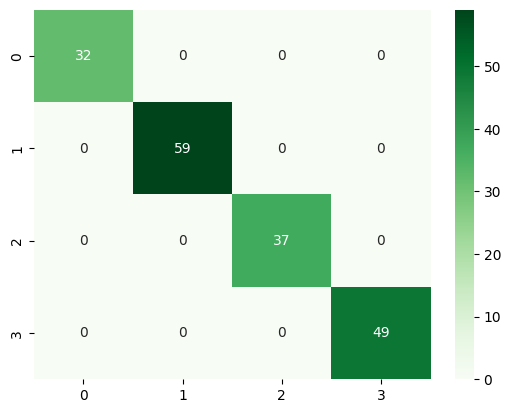

In [54]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Greens')

# **Random Forest**

In [55]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 0, criterion = 'entropy')
RF.fit(x_train, y_train)
y_pred = RF.predict(x_test)

In [56]:
#to calculate error
RF.score(x_test, y_test)
#ORRR
RF.score(x_train, y_train)

0.9985795454545454

In [57]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = 'weighted'))
print(precision_score(y_test, y_pred, average = 'weighted'))
print(recall_score(y_test, y_pred, average = 'weighted'))

[[32  0  0  0]
 [ 0 59  0  0]
 [ 0  0 37  0]
 [ 0  0  0 49]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        37
           3       1.00      1.00      1.00        49

    accuracy                           1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177

1.0
1.0
1.0
1.0


In [58]:
data = {
    'y_test': y_test,
    'y_pred': y_pred,
    'diff' : y_test - y_pred
}
df = pd.DataFrame(data)
df.head()

,y_test,y_pred,diff
350,1,1,0
254,1,1,0
490,0,0,0
688,1,1,0
393,1,1,0


<Axes: >

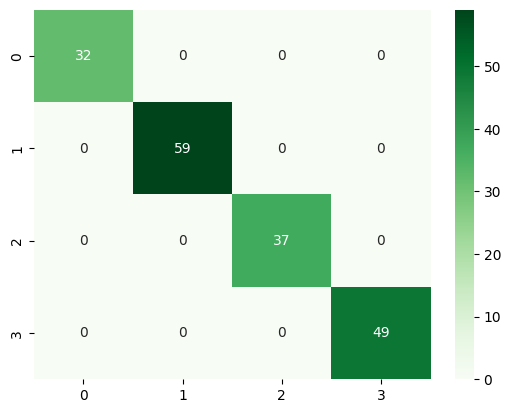

In [59]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap = 'Greens')

# **Logistic Regression**

In [60]:
from sklearn.linear_model import LogisticRegression
LG = LogisticRegression()
LG.fit(x_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [61]:
LG.coef_, LG.intercept_ #values of theta and constant (theta(0) + theta(1)*x)

(array([[ 3.24026274e-03, -2.15630929e-03, -3.30803614e-03,
         -5.52029341e-03,  3.43978521e-04,  2.96433669e-04,
          9.26982566e-04, -5.59906070e-03, -2.10316738e-04,
          1.44539348e-03,  5.37058527e-03,  1.86467133e-03,
          4.71787283e-03,  5.44994108e-03, -1.02511273e-03,
          1.39535750e-03, -2.16801520e-03,  1.67307752e-03,
          1.09676138e-03, -1.33956246e-03, -1.68824275e-03,
         -8.84923563e-04, -7.48546892e-05, -9.32862897e-04,
          8.25358443e-04,  5.67797759e-04,  1.05817565e-03,
         -1.68498538e-03, -2.30383228e-03, -6.17469758e-03,
         -4.32957994e-03,  5.63735179e-03,  5.19433684e-03,
          2.12827112e-03, -8.42022719e-04, -5.61097115e-04,
         -8.31036025e-04, -3.06477705e-06],
        [-5.83958609e-03,  2.48594079e-03,  2.73067204e-03,
          3.70407423e-03,  1.56084093e-03,  1.93274710e-03,
          9.79760879e-04,  3.45270911e-03,  2.85576188e-03,
         -7.16646048e-03, -9.09290582e-03,  1.86761114e-

In [62]:
LG.coef_.shape

(5, 38)

In [63]:
LG.intercept_.shape

(5,)

In [64]:
#to calculate error
LG.score(x_test, y_test)
#ORRR
LG.score(x_train, y_train)

0.40625

In [65]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average = 'weighted'))
print(recall_score(y_test, y_pred, average = 'weighted'))
print(f1_score(y_test, y_pred, average = 'weighted'))

[[32  0  0  0]
 [ 0 59  0  0]
 [ 0  0 37  0]
 [ 0  0  0 49]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        37
           3       1.00      1.00      1.00        49

    accuracy                           1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177

1.0
1.0
1.0
1.0


In [66]:
data = {
    'y_test': y_test,
    'y_pred': y_pred,
    'diff' : y_test - y_pred
}
df = pd.DataFrame(data)
df.head()

,y_test,y_pred,diff
350,1,1,0
254,1,1,0
490,0,0,0
688,1,1,0
393,1,1,0


<Axes: >

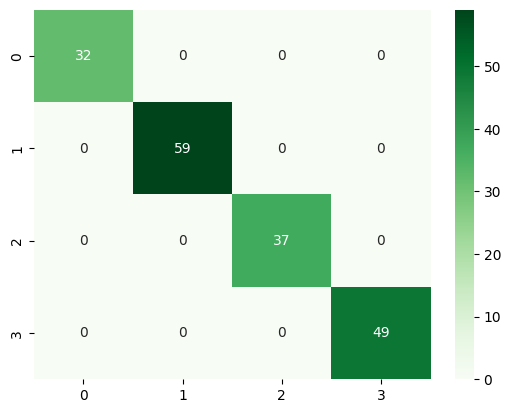

In [67]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap = 'Greens')